Terrain CRS: EPSG:27700
Terrain bounds: BoundingBox(left=0.00012004771269857883, bottom=-0.0003991583362221718, right=660000.0001200477, top=1229999.9996008417)
REPD rows, cols: (13524, 53)
Columns preview: ['Old Ref ID', 'Ref ID', 'Record Last Updated (dd/mm/yyyy)', 'Operator (or Applicant)', 'Site Name', 'Technology Type', 'Storage Type', 'Storage Co-location REPD Ref ID', 'Installed Capacity (MWelec)', 'Share Community Scheme', 'CHP Enabled', 'CfD Allocation Round']
Wind Onshore (cleaned) rows: 2561
Development Status top counts:
 Development Status
Operational                       772
Planning Permission Refused       356
Planning Application Withdrawn    272
Planning Permission Granted       255
Planning Application Submitted    241
Revised                           231
Appeal Refused                    201
Planning Permission Expired        57
Abandoned                          54
Under Construction                 40
Appeal Withdrawn                   31
Appeal Granted         

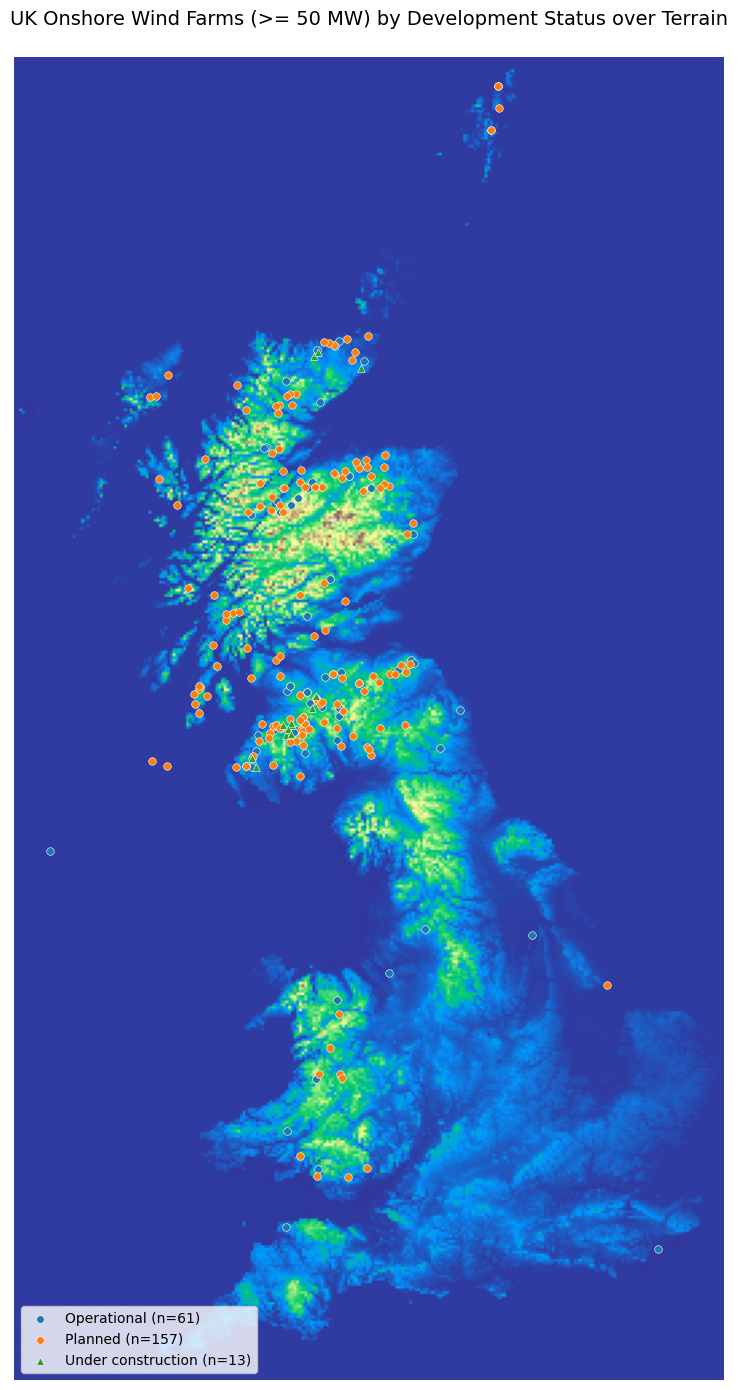


✅ Map saved to: uk_onshore_windfarms_threshold_50MW.png


<Figure size 640x480 with 0 Axes>

✅ 图已经保存到桌面 2nd_Assignment-20251222 文件夹里了！


In [3]:


import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt



TERRAIN_PATH = "/Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/terrain.tif"


WIND_CSV_PATH = "/Users/wangbobo/Desktop/2nd_Assignment-20251222/REPD_Publication_Q3_2025.csv"


if not os.path.exists(TERRAIN_PATH):
    print("⚠️ 未找到本地 TERRAIN_PATH，改用 fallback: /mnt/data/terrain.tif")
    TERRAIN_PATH = "/mnt/data/terrain.tif"

if not os.path.exists(WIND_CSV_PATH):
    
    fallback_csv = "/mnt/data/REPD_Publication_Q3_2025.csv"
    if os.path.exists(fallback_csv):
        print("⚠️ 未找到本地 WIND_CSV_PATH，改用 fallback: /mnt/data/REPD_Publication_Q3_2025.csv")
        WIND_CSV_PATH = fallback_csv
    else:
        raise FileNotFoundError("找不到风电场 CSV。请确认 WIND_CSV_PATH 文件名/路径是否正确。")



with rasterio.open(TERRAIN_PATH) as src:
    terrain_crs = src.crs
    terrain_bounds = src.bounds
    terrain_transform = src.transform

print("Terrain CRS:", terrain_crs)
print("Terrain bounds:", terrain_bounds)


# ==========================================
# 3) 读取 REPD CSV（注意编码）
# ==========================================
# REPD 文件常见不是 utf-8，所以这里用 latin1 更稳
df = pd.read_csv(WIND_CSV_PATH, encoding="latin1", low_memory=False)
print("REPD rows, cols:", df.shape)
print("Columns preview:", df.columns[:12].tolist())


# ==========================================================
# 4) 筛选“陆上风电 (Wind Onshore)” + 坐标 + 容量字段清洗
# ==========================================================
# 关键列名（REPD Q3 2025 版本常见字段）
COL_TECH = "Technology Type"
COL_STATUS = "Development Status"
COL_CAP = "Installed Capacity (MWelec)"
COL_X = "X-coordinate"
COL_Y = "Y-coordinate"

# 只要陆上风电
wind_on = df[df[COL_TECH].astype(str).str.contains("Wind Onshore", na=False)].copy()

# 容量转数值
wind_on["cap_mw"] = pd.to_numeric(wind_on[COL_CAP], errors="coerce")

# 坐标转数值
wind_on[COL_X] = pd.to_numeric(wind_on[COL_X], errors="coerce")
wind_on[COL_Y] = pd.to_numeric(wind_on[COL_Y], errors="coerce")

# 丢掉没有坐标/容量的行
wind_on = wind_on.dropna(subset=[COL_X, COL_Y, "cap_mw"]).copy()

print("Wind Onshore (cleaned) rows:", len(wind_on))
print("Development Status top counts:\n", wind_on[COL_STATUS].value_counts().head(15))


# ==========================================================
# 5) 先做容量分布诊断，帮你决定合适阈值
# ==========================================================
print("\nCapacity (MW) summary:")
print(wind_on["cap_mw"].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]))

for th in [10, 20, 30, 50, 75, 100]:
    print(f"Count >= {th:>3} MW: {(wind_on['cap_mw'] >= th).sum():>5}")


# ==========================================================
# 6) 设定阈值并分类：Operational / Under construction / Planned
# ==========================================================
CAPACITY_THRESHOLD_MW = 50  # ✅ 你可以改成 20 或 30 等

# 定义“规划/计划中”的状态白名单（排除 refused/withdrawn/abandoned/expired 等）
planned_status_allow = {
    "Planning Application Submitted",
    "Planning Permission Granted",
    "Revised",
    "Appeal Granted",
    "Secretary of State - Granted",
    "Appeal Lodged",
    "No Application Required",
    # 如你希望更宽松/更严格，可在这里增删
}

def map_status(s):
    s = str(s)
    if s == "Operational":
        return "Operational"
    if s == "Under Construction":
        return "Under construction"
    if s in planned_status_allow:
        return "Planned"
    return "Other / Excluded"

wind_on["status3"] = wind_on[COL_STATUS].apply(map_status)

# 只保留三类 + 容量阈值
wind_sel = wind_on[
    (wind_on["cap_mw"] >= CAPACITY_THRESHOLD_MW) &
    (wind_on["status3"].isin(["Operational", "Under construction", "Planned"]))
].copy()

print("\nAfter threshold + status filter:")
print("Threshold MW:", CAPACITY_THRESHOLD_MW)
print(wind_sel["status3"].value_counts())


# ==========================================================
# 7) 转成 GeoDataFrame（CRS 与 terrain.tif 一致：EPSG:27700）
# ==========================================================
gdf = gpd.GeoDataFrame(
    wind_sel,
    geometry=gpd.points_from_xy(wind_sel[COL_X], wind_sel[COL_Y]),
    crs="EPSG:27700"  # REPD 的 X/Y 通常就是 OSGB 27700
)

# 裁剪到栅格范围（可选，但能避免“飞点”）
xmin, ymin, xmax, ymax = terrain_bounds
gdf = gdf.cx[xmin:xmax, ymin:ymax]

print("GDF rows in terrain extent:", len(gdf))


# ==========================================================
# 8) 绘图：terrain 底图 + 三类风场点
# ==========================================================
fig, ax = plt.subplots(1, 1, figsize=(10, 14))

# 画栅格底图
with rasterio.open(TERRAIN_PATH) as src:
    # terrain 栅格通常是高程值，用 show 绘制并带 colorbar
    img = show(src, ax=ax, cmap="terrain")  # 你也可以换成 "Greys" 等

# 叠加点（用不同 marker 区分；颜色交给 geopandas/matplotlib 默认）
markers = {
    "Operational": "o",
    "Planned": "o",
    "Under construction": "^"
}

# 为了让 Planned/Operational 不完全重叠，你也可以给不同大小或透明度
for cat in ["Operational", "Planned", "Under construction"]:
    sub = gdf[gdf["status3"] == cat]
    sub.plot(
        ax=ax,
        markersize=30,
        marker=markers[cat],
        linewidth=0.4,
        edgecolor="white",
        label=f"{cat} (n={len(sub)})"
    )

ax.set_title(
    f"UK Onshore Wind Farms (>= {CAPACITY_THRESHOLD_MW} MW) by Development Status over Terrain",
    fontsize=14,
    pad=12
)

ax.set_axis_off()
ax.legend(loc="lower left", frameon=True)

# 保存输出
out_png = f"uk_onshore_windfarms_threshold_{CAPACITY_THRESHOLD_MW}MW.png"
plt.tight_layout()
plt.savefig(out_png, dpi=300, bbox_inches="tight")
plt.show()

print(f"\n✅ Map saved to: {out_png}")
SAVE_DIR = "/Users/wangbobo/Desktop"
import os

SAVE_DIR = "/Users/wangbobo/Desktop/2nd_Assignment-20251222"
os.makedirs(SAVE_DIR, exist_ok=True)

plt.savefig(
    os.path.join(SAVE_DIR, "uk_onshore_windfarms_50MW.png"),
    dpi=300,
    bbox_inches="tight"
)

plt.show()

print("✅ 图已经保存到桌面 2nd_Assignment-20251222 文件夹里了！")



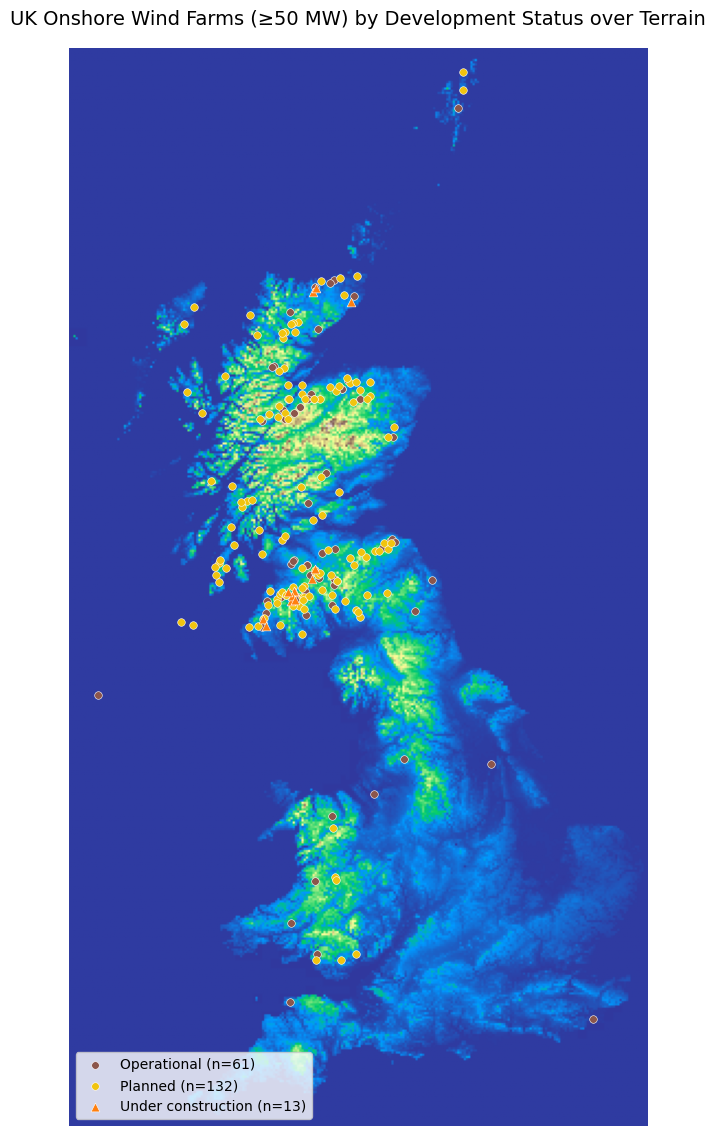

✅ 图片已成功保存到：
/Users/wangbobo/Desktop/2nd_Assignment-20251222/uk_onshore_windfarms_50MW.png


In [4]:

import os
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt



TERRAIN_PATH = "/Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/terrain.tif"
WIND_CSV_PATH = "/Users/wangbobo/Desktop/2nd_Assignment-20251222/REPD_Publication_Q3_2025.csv"

SAVE_DIR = "/Users/wangbobo/Desktop/2nd_Assignment-20251222"
OUTPUT_PNG = "uk_onshore_windfarms_50MW.png"

os.makedirs(SAVE_DIR, exist_ok=True)
OUT_PATH = os.path.join(SAVE_DIR, OUTPUT_PNG)



terrain = rasterio.open(TERRAIN_PATH)



df = pd.read_csv(WIND_CSV_PATH, encoding="latin1", low_memory=False)



df = df[df["Technology Type"].str.contains("Wind Onshore", na=False)].copy()


df["cap_mw"] = pd.to_numeric(df["Installed Capacity (MWelec)"], errors="coerce")
df["X"] = pd.to_numeric(df["X-coordinate"], errors="coerce")
df["Y"] = pd.to_numeric(df["Y-coordinate"], errors="coerce")

df = df.dropna(subset=["cap_mw", "X", "Y"])



CAPACITY_THRESHOLD = 50
df = df[df["cap_mw"] >= CAPACITY_THRESHOLD].copy()



def classify_status(s):
    s = str(s)
    if s == "Operational":
        return "Operational"
    if s == "Under Construction":
        return "Under construction"
    if s in [
        "Planning Permission Granted",
        "Planning Application Submitted",
        "Appeal Granted",
        "Secretary of State - Granted"
    ]:
        return "Planned"
    return None

df["status"] = df["Development Status"].apply(classify_status)
df = df.dropna(subset=["status"])



gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["X"], df["Y"]),
    crs="EPSG:27700"
)



fig, ax = plt.subplots(figsize=(10, 14))

# 底图：terrain
show(terrain, ax=ax, cmap="terrain")

# 点图
gdf[gdf["status"] == "Operational"].plot(
    ax=ax, marker="o", color="#8c564b", markersize=30,
    label=f"Operational (n={sum(gdf['status']=='Operational')})",
    edgecolor="white", linewidth=0.4
)

gdf[gdf["status"] == "Planned"].plot(
    ax=ax, marker="o", color="#f1c40f", markersize=30,
    label=f"Planned (n={sum(gdf['status']=='Planned')})",
    edgecolor="white", linewidth=0.4
)

gdf[gdf["status"] == "Under construction"].plot(
    ax=ax, marker="^", color="#ff7f0e", markersize=40,
    label=f"Under construction (n={sum(gdf['status']=='Under construction')})",
    edgecolor="white", linewidth=0.4
)

ax.set_title(
    "UK Onshore Wind Farms (≥50 MW) by Development Status over Terrain",
    fontsize=14
)

ax.legend(loc="lower left")
ax.axis("off")



fig.savefig(OUT_PATH, dpi=300, bbox_inches="tight")
plt.show()

print("✅ 图片已成功保存到：")
print(OUT_PATH)
